<!-- ## Internal Notes: to be deleted.

1 TODO: Let's implement a `return_full_text` field so the user can demand a model
does not include the the input text as well in its response
see https://huggingface.co/docs/transformers/v4.17.0/main_classes/pipelines

2 pip installing Oumi with [.gpu] it does not include ipywidgets which disables the monitoring of 
tqdm inside the notebook and results below in: `TqdmWarning: IProgress not found. Please update jupyter and ipywidgets`
Handling it with `!pip install ipywidgets`, TODO: Can we do better?


!pip install ipywidgets # Installing ipywidgets for widget visualization -->

# Finetuning a Vision-Language Model (Overview)

In this tutorial, we'll use SFT training to guide a large vision/language model to produce short and concise answer grounded on visual input.

Specifically, we'll use the Oumi framework to streamline the process and achieve high-quality results fast.

We'll cover the following topics:
1. Prerequisites
2. Data Preparation & Sanity Checks
3. Training Config Preparation
4. Launching Training
5. Inference

# Prerequisites
## Oumi Installation
First, let's install Oumi and some additional packages. You can find detailed instructions [here](https://github.com/oumi-ai/oumi/blob/main/README.md), but for Oumi it should be as simple as:

```bash
pip install -e ".[gpu]"  # if you have an nvidia or AMD GPU
# OR
pip install -e "."  # if you don't have a GPU
```

In [ ]:
# Additionally, install the following packages for widget visualization.
!pip install ipywidgets

# Also, deactivate the parallelism warning from the tokenizers library.
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"  # deactivate relevant HF warnings

## Creating our working directory

For our experiments, we'll use the following folder to save the model, training artifacts, and our inference and training configs.

In [1]:
from pathlib import Path

tutorial_dir = "vision_language_tutorial"

Path(tutorial_dir).mkdir(parents=True, exist_ok=True)

In what follows we use the [Qwen2-VL](https://github.com/QwenLM/Qwen2-VL) model.

Qwen2-VL is a high-performing multi-modal model which uses a modest amount of resources (2B parameters).

We will finetune this model with the [vqav2-small](https://huggingface.co/datasets/merve/vqav2-small) dataset which will help the model respond in a succinct manner on visually grounded questions.

The principles presented here are generic and "Oumi-flexible". 

To repeat the exercise with other models/data you can simply replace e.g., the `model_name` (a string) with the names of other supported models (see [here](https://oumi.ai/docs/latest/resources/models/supported_models.html)) and adapt the configurations.

## First, let's initialize our dataset and build a tokenizer and an underlying processor.


In [2]:
from oumi.builders import build_tokenizer
from oumi.core.configs import ModelParams
from oumi.datasets.vision_language.vqav2_small import Vqav2SmallDataset

model_name = "Qwen/Qwen2-VL-2B-Instruct"

tokenizer = build_tokenizer(ModelParams(model_name=model_name))

dataset = Vqav2SmallDataset(
    tokenizer=tokenizer,
    processor_name=model_name,
    limit=2000,  # Limit the number of examples for demonstration purposes (!)
)

print("\nExamples included:", len(dataset))

[2025-01-26 16:03:45,746][oumi][rank0][pid:1194][MainThread][INFO]][models.py:427] Using the chat template 'qwen2-vl-instruct', which is the default for model 'Qwen/Qwen2-VL-2B-Instruct'.
[2025-01-26 16:03:45,747][oumi][rank0][pid:1194][MainThread][INFO]][base_map_dataset.py:68] Creating map dataset (type: Vqav2SmallDataset) dataset_name: 'None', dataset_path: 'None'...
[2025-01-26 16:03:48,040][oumi][rank0][pid:1194][MainThread][INFO]][base_map_dataset.py:472] Dataset Info:
	Split: validation
	Version: 0.0.0
	Dataset size: 3391008667
	Download size: 3376516283
	Size: 6767524950 bytes
	Rows: 21435
	Columns: ['multiple_choice_answer', 'question', 'image']
[2025-01-26 16:03:54,046][oumi][rank0][pid:1194][MainThread][INFO]][base_map_dataset.py:411] Loaded DataFrame with shape: (21435, 3). Columns:
multiple_choice_answer    object
question                  object
image                     object
dtype: object

Examples included: 2000


### Now let's see a few examples to get a feel for the dataset we are going to use.

Example 1:


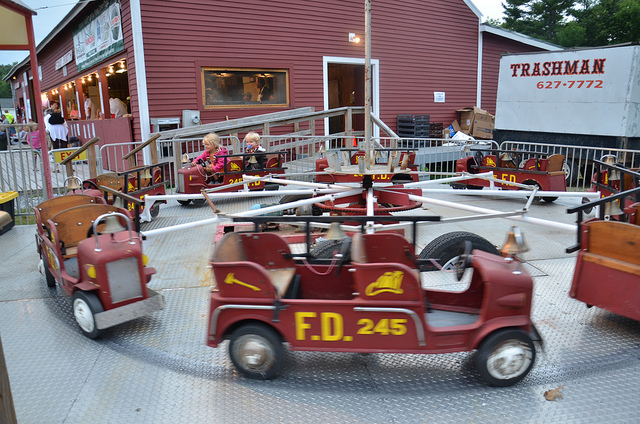

user: [<IMAGE_BINARY>, Where are the kids riding?]
assistant: carnival ride


Example 2:


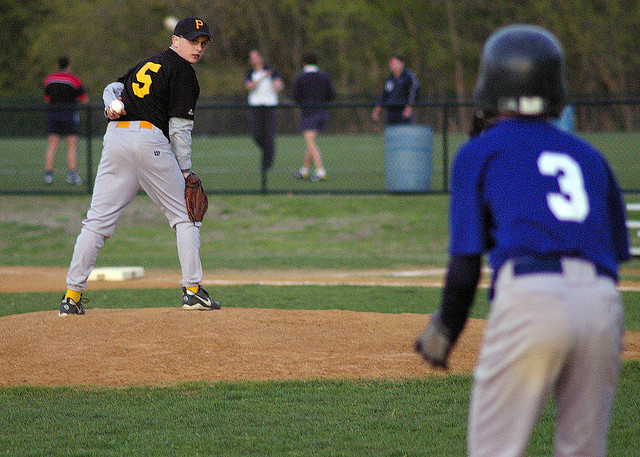

user: [<IMAGE_BINARY>, Is this boy a good pitcher?]
assistant: yes




In [3]:
import io

from PIL import Image

from oumi.core.types.conversation import Type

num_examples_to_display = 2

for i in range(num_examples_to_display):
    conversation = dataset.conversation(i)  # retrieve the i-th example (conversation)

    print(f"Example {i + 1}:")

    for message in conversation.messages:
        if message.role == "user":  # The `user` poses a question, regarding an image
            img_content = message.content[0]
            assert (
                img_content.type == Type.IMAGE_BINARY
            ), "Oumi encodes image content in binary for VQA-Small."

            image = Image.open(io.BytesIO(img_content.binary))
            image.save(f"{tutorial_dir}/example_{i}.jpg")  # optionally save the image
            display(image)

        print(f"{message.role}: {message.content}")
    print("\n")

As we can see above the ground-truth answers are **very short and succinct**, which can be an advantage for scenarios where we want to generate concise answers.

In [ ]:
# Furthermore, if you want to see directly the underlying stored data, stored in a
# pandas DataFrame, you can do so by running the following command:
dataset.data.head()

## Initial Model Responses

Let's see how our model performs on an example prompt without any finetuning.
- For this we will create and execute and `inference configuration` stored in a YAML file.

In [ ]:
%%writefile $tutorial_dir/infer.yaml

model:
  model_name: "Qwen/Qwen2-VL-2B-Instruct"
  torch_dtype_str: "bfloat16" # good choice if you have access to Ampere or newer GPU
  chat_template: "qwen2-vl-instruct"
  model_max_length: 4096
  trust_remote_code: True
  
generation:
  max_new_tokens: 64
  batch_size: 1
  
engine: NATIVE 
# Let's use the `native` engine (i.e., the underlying machine's default) for inference.  
# You can also consider VLLM, if are working with GPU for much faster inference. 
# To install it with Oumi: 
# pip install ".[optional]"

In [ ]:
from oumi.core.configs import InferenceConfig
from oumi.infer import infer

config = InferenceConfig.from_yaml(str(Path(tutorial_dir) / "infer.yaml"))

# Use first data example here as input
conversation_id = 0
query_img = dataset.conversation(conversation_id).messages[0].image_content_items
query_text = dataset.conversation(conversation_id).messages[0].text_content_items
query_text_string = query_text[0].content
print(f"\n{query_text_string}")

In [ ]:
from oumi.inference import NativeTextInferenceEngine

inference_engine = NativeTextInferenceEngine(config.model)
inference_engine.infer([dataset.conversation(0)], config)  # does not seem to work

In [ ]:
from oumi.utils.image_utils import create_png_bytes_from_image

test_image = Image.open(f"{tutorial_dir}/example_{0}.jpg")
image_bytes = create_png_bytes_from_image(test_image)

results = infer(
    config=config,
    inputs=[query_text_string],
    input_image_bytes=image_bytes,  # this works
    #     input_image_bytes=query_img[0].binary, # does not seem to work with this
)

results

In [ ]:
## temporary-note: # this works too
# Note. You can do the same inference directly with our CLI client instead of the
# Python API. E.g., uncomment the following line and execute this cell:

# !echo "$query_text_string" | oumi infer -c "$tutorial_dir/infer.yaml" -i --image="$tutorial_dir/example_0.jpg" # noqa: E501

OK! That's good -- but as you can see by default the model gives quite verbose responses. 

## Preparing our training experiment
 - Specifically, let's create an execute a YAML file with our training config!

In [ ]:
%%writefile $tutorial_dir/train.yaml

model:
  model_name: "Qwen/Qwen2-VL-2B-Instruct"
  torch_dtype_str: "bfloat16"
  model_max_length: 4096
  trust_remote_code: True
  attn_implementation: "sdpa"
  chat_template: "qwen2-vl-instruct"
  freeze_layers:
    - "visual"     # Let's finetune only the language component of the model

data:
  train:
    collator_name: "vision_language_with_padding" # simple padding collator
    experimental_use_torch_datapipes: True

    datasets:
      - dataset_name: "merve/vqav2-small"
        split: "validation" # This dataset has only a validation split
        shuffle: True
        seed: 42
        transform_num_workers: "auto"
        dataset_kwargs:
          processor_name: "Qwen/Qwen2-VL-2B-Instruct" # i.e., the default for our model
          limit: 2000 # Again, we downsample to 2,000 examplesfor demonstration purposes only.
          return_tensors: True      

training:
  output_dir: "vision_language_tutorial"
  trainer_type: "TRL_SFT"
  enable_gradient_checkpointing: True
  per_device_train_batch_size: 1 # Must be 1: the model generates variable-sized image features.
  gradient_accumulation_steps: 32
  
  # ***NOTE***
  # We set `max_steps` to 20 steps to first verify that it works
  # Swap to `num_train_epochs: 1` to get more meaningful results.
  # Note: 1 training epoch will take ~11 mins on a single A100-40GB GPU and 2,000 examples.
  max_steps: 20
  # num_train_epochs: 1

  gradient_checkpointing_kwargs:
    # Reentrant docs: https://pytorch.org/docs/stable/checkpoint.html#torch.utils.checkpoint.checkpoint
    use_reentrant: False
  ddp_find_unused_parameters: False
  empty_device_cache_steps: 1

  optimizer: "adamw_torch_fused"
  learning_rate: 2e-5
  warmup_ratio: 0.03
  weight_decay: 0.0
  lr_scheduler_type: "cosine"

  logging_steps: 5
  save_steps: 0
  dataloader_main_process_only: False
  dataloader_num_workers: 2
  dataloader_prefetch_factor: 8
  include_performance_metrics: True
  enable_wandb: True # Set to False if you don't want to use Weights & Biases

In [ ]:
## Let's launch the training!

!oumi train -c "$tutorial_dir/train.yaml"

## Finally, let's use the Fine-tuned Model and see the effect of training!

Once we're happy with the results, we can serve the fine-tuned model for interactive inference:

In [ ]:
%%writefile $tutorial_dir/trained_infer.yaml

model:
  model_name: "vision_language_tutorial"  
  torch_dtype_str: "bfloat16"
  chat_template: "qwen2-vl-instruct"
  model_max_length: 4096
  trust_remote_code: True

generation:
  max_new_tokens: 256
  batch_size: 1
  
engine: NATIVE

In [ ]:
config = InferenceConfig.from_yaml(str(Path(tutorial_dir) / "trained_infer.yaml"))


test_image = Image.open(f"{tutorial_dir}/example_{0}.jpg")
image_bytes = create_png_bytes_from_image(test_image)

results = infer(
    config=config,
    inputs=[query_text_string],
    input_image_bytes=image_bytes,
)

results